## DistillBert ..................**bold text**

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shutil


file_path = "/content/educational_dataset+non.csv"
data = pd.read_csv(file_path)


data = data.dropna()
data['Query'] = data['Query'].str.strip()


label_mapping = {"educational": 1, "noneducational": 0}
data["Classification"] = data["Classification"].map(label_mapping)


print(f"Class distribution:\n{data['Classification'].value_counts()}")


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)


def preprocess_data(examples):

    inputs = tokenizer(examples["Query"], truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = examples["Classification"]
    return inputs

train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)


train_dataset = train_dataset.remove_columns(["Query", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["Query", "__index_level_0__"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()


model_dir = "./fine_tuned_model"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

import shutil
zip_filename = "/content/fine_tuned_model.zip"
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', model_dir)

print(f"Model saved as {zip_filename}")


Class distribution:
Classification
1    9893
0    6874
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13413 [00:00<?, ? examples/s]

Map:   0%|          | 0/3354 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-c0ded096accf>:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.002100,0.003707,0.999404,0.998965,1.000000,0.999482
2,0.000100,0.002853,0.999404,0.998965,1.000000,0.999482
3,0.000100,0.002583,0.999404,0.998965,1.000000,0.999482


Model saved as /content/fine_tuned_model.zip


In [ ]:
from google.colab import files


files.download('/content/fine_tuned_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Map:   0%|          | 0/3354 [00:00<?, ? examples/s]

<ipython-input-2-1536a557758c>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


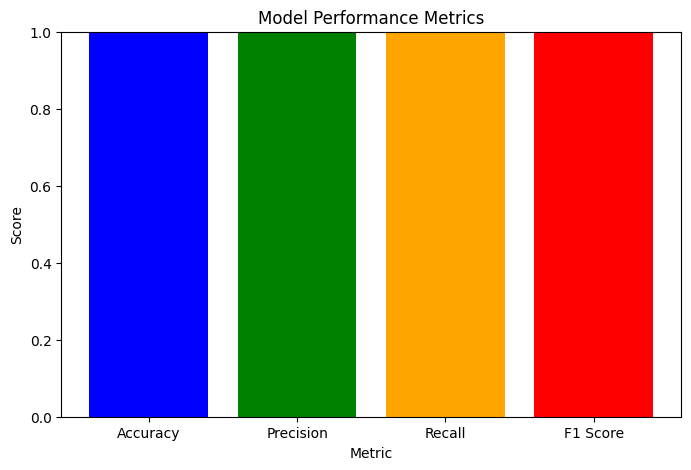

In [2]:
import zipfile
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.model_selection import train_test_split


zip_file_path = "/content/fine_tuned_model.zip"
extract_dir = "./fine_tuned_model"
if os.path.exists(zip_file_path):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    except zipfile.BadZipFile:
        raise ValueError("The file is not a valid ZIP archive.")
else:
    raise FileNotFoundError("ZIP file does not exist.")


model = AutoModelForSequenceClassification.from_pretrained(extract_dir)
tokenizer = AutoTokenizer.from_pretrained(extract_dir)


file_path = "/content/educational_dataset+non.csv"
data = pd.read_csv(file_path)
data = data.dropna()
data['Query'] = data['Query'].str.strip()
label_mapping = {"educational": 1, "noneducational": 0}
data["Classification"] = data["Classification"].map(label_mapping)

_, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_dataset = Dataset.from_pandas(test_data)


def preprocess_data(examples):
    inputs = tokenizer(examples["Query"], truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = examples["Classification"]
    return inputs

test_dataset = test_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.remove_columns(["Query", "__index_level_0__"])
test_dataset.set_format("torch")

def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset)

logits = predictions.predictions
labels = predictions.label_ids
metrics = compute_metrics((logits, labels))


metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
metric_values = [metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1"]]

plt.figure(figsize=(8, 5))
plt.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.show()


**DistilBert by using PEFT**

In [1]:
pip install transformers datasets scikit-learn peft matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13413 [00:00<?, ? examples/s]

Map:   0%|          | 0/3354 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-8b71155f7135>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.019800,0.018939,0.994931
2,0.018900,0.010844,0.998211
3,0.005800,0.011021,0.998211


Evaluation Results: {'eval_loss': 0.011021297425031662, 'eval_accuracy': 0.998211091234347, 'eval_runtime': 13.1688, 'eval_samples_per_second': 254.693, 'eval_steps_per_second': 15.947, 'epoch': 3.0}
Accuracy: 1.00
Classification Report:
                 precision    recall  f1-score   support

noneducational       1.00      1.00      1.00      1424
   educational       1.00      1.00      1.00      1930

      accuracy                           1.00      3354
     macro avg       1.00      1.00      1.00      3354
  weighted avg       1.00      1.00      1.00      3354



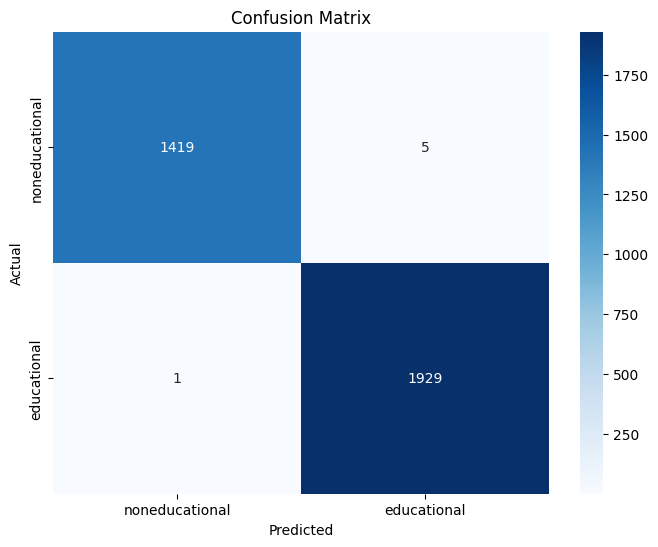

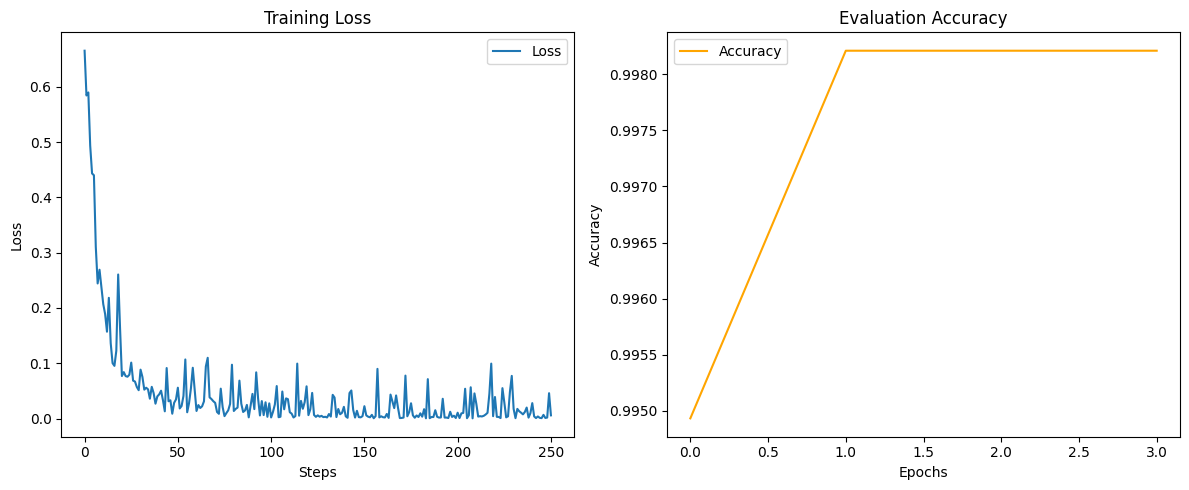

In [5]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
data = pd.read_csv("/content/educational_dataset+non.csv")
data = data.dropna()
data['Query'] = data['Query'].str.strip()
label_mapping = {"educational": 1, "noneducational": 0}
data["Classification"] = data["Classification"].map(label_mapping)

# Split dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

# Preprocess data
def preprocess_data(examples):
    inputs = tokenizer(examples["Query"], truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = examples["Classification"]
    return inputs

train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

train_dataset = train_dataset.remove_columns(["Query", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["Query", "__index_level_0__"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")

# Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type=TaskType.SEQ_CLS,
    target_modules=["q_lin", "v_lin"]  # Corrected for DistilBERT
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10
)

# Metrics calculation
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Predict on the test set
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Accuracy
test_labels = torch.cat([x["labels"].unsqueeze(0) for x in test_dataset]).numpy()
accuracy = accuracy_score(test_labels, pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
report = classification_report(test_labels, pred_labels, target_names=["noneducational", "educational"])
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["noneducational", "educational"], yticklabels=["noneducational", "educational"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Loss and accuracy plots (training logs)
log_history = trainer.state.log_history

# Extract loss and accuracy
losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_accuracies = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_accuracies, label="Accuracy", color="orange")
plt.title("Evaluation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
